<a href="https://colab.research.google.com/github/AloniRegev/Defense-Against-Adversarial-Examples-in-NN/blob/Neta-dev/DL_project_adversary_attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CUDA available. Training on GPU
Files already downloaded and verified
Files already downloaded and verified
train set len 40000
validation set len 10000
test set len 10000
Iteration: 0 | Loss: 2.304537296295166 | index 0 
Iteration: 0 | Loss: 1.5768530368804932 | index 100 
Iteration: 0 | Loss: 1.6090269088745117 | index 200 
Iteration: 0 | Loss: 1.4832428693771362 | index 300 
Iteration: 0 | Loss: 1.3704606294631958 | index 400 
Iteration: 0 | Loss: 1.4345405101776123 | index 500 
Iteration: 0 | Loss: 1.0498054027557373 | index 600 
Accuracy: in train 0.4258999824523926


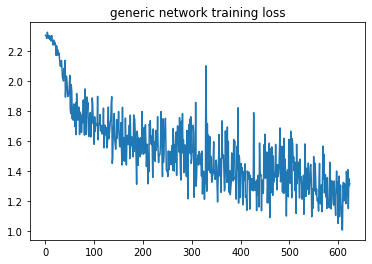

Accuracy: in validation 0.5116999745368958
The Current Loss by validation data: 1.359897278676367
Iteration: 1 | Loss: 1.2572250366210938 | index 0 
Iteration: 1 | Loss: 1.2816253900527954 | index 100 
Iteration: 1 | Loss: 1.139886498451233 | index 200 
Iteration: 1 | Loss: 0.8864685893058777 | index 300 
Iteration: 1 | Loss: 1.0842632055282593 | index 400 
Iteration: 1 | Loss: 1.1517174243927002 | index 500 
Iteration: 1 | Loss: 0.7212895154953003 | index 600 
Accuracy: in train 0.5118374824523926


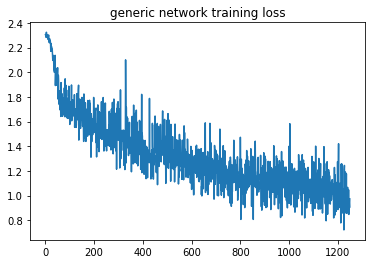

Accuracy: in validation 0.5730999708175659
The Current Loss by validation data: 1.2424587258108102
Iteration: 2 | Loss: 0.7775037884712219 | index 0 
Iteration: 2 | Loss: 0.9784397482872009 | index 100 
Iteration: 2 | Loss: 0.7898889780044556 | index 200 
Iteration: 2 | Loss: 1.0647727251052856 | index 300 
Iteration: 2 | Loss: 0.7046436667442322 | index 400 
Iteration: 2 | Loss: 1.0134508609771729 | index 500 
Iteration: 2 | Loss: 0.7086427807807922 | index 600 
Accuracy: in train 0.5648083686828613


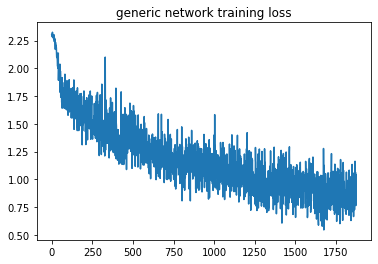

Accuracy: in validation 0.6728000044822693
The Current Loss by validation data: 0.9295617873501626
Iteration: 3 | Loss: 0.9077364206314087 | index 0 
Iteration: 3 | Loss: 0.7793728709220886 | index 100 
Iteration: 3 | Loss: 0.9128054976463318 | index 200 
Iteration: 3 | Loss: 0.7945026159286499 | index 300 
Iteration: 3 | Loss: 0.8248353004455566 | index 400 
Iteration: 3 | Loss: 0.549139142036438 | index 500 
Iteration: 3 | Loss: 0.7205924391746521 | index 600 
Accuracy: in train 0.6037874817848206


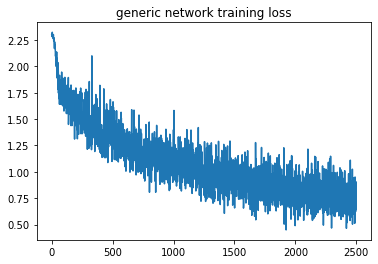

Accuracy: in validation 0.6504999995231628
The Current Loss by validation data: 1.0786776352839864
Iteration: 4 | Loss: 0.8779215812683105 | index 0 
Iteration: 4 | Loss: 0.6074838638305664 | index 100 
Iteration: 4 | Loss: 0.7994388341903687 | index 200 
Iteration: 4 | Loss: 0.6804398894309998 | index 300 
Iteration: 4 | Loss: 0.46647587418556213 | index 400 
Iteration: 4 | Loss: 0.38350909948349 | index 500 
Iteration: 4 | Loss: 0.8830083012580872 | index 600 
Accuracy: in train 0.6335449814796448


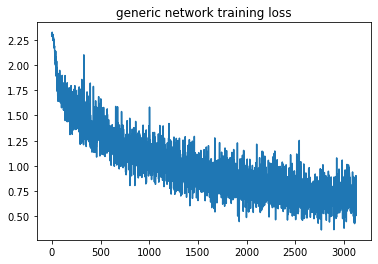

Accuracy: in validation 0.6847000122070312
The Current Loss by validation data: 0.9416318023280733
Iteration: 5 | Loss: 0.6996960639953613 | index 0 
Iteration: 5 | Loss: 0.6602473258972168 | index 100 
Iteration: 5 | Loss: 0.491752564907074 | index 200 
Iteration: 5 | Loss: 0.6914257407188416 | index 300 
Iteration: 5 | Loss: 0.5284328460693359 | index 400 
Iteration: 5 | Loss: 0.5433335900306702 | index 500 
Iteration: 5 | Loss: 0.47002264857292175 | index 600 
Accuracy: in train 0.6573958396911621


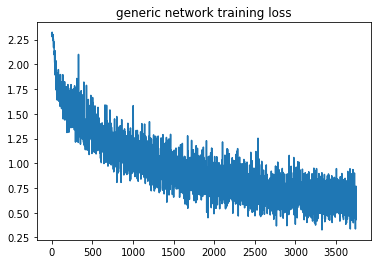

Accuracy: in validation 0.7240999937057495
The Current Loss by validation data: 0.8243617747619654
Iteration: 6 | Loss: 0.3673095405101776 | index 0 
Iteration: 6 | Loss: 0.4592306911945343 | index 100 
Iteration: 6 | Loss: 0.6306215524673462 | index 200 
Iteration: 6 | Loss: 0.5846506953239441 | index 300 
Iteration: 6 | Loss: 0.6408687829971313 | index 400 
Iteration: 6 | Loss: 0.6594853401184082 | index 500 
Iteration: 6 | Loss: 0.5535052418708801 | index 600 
Accuracy: in train 0.6774250268936157


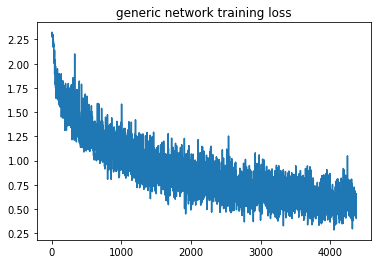

Accuracy: in validation 0.7518999576568604
The Current Loss by validation data: 0.731912998446993
Iteration: 7 | Loss: 0.4629139304161072 | index 0 
Iteration: 7 | Loss: 0.6007859706878662 | index 100 
Iteration: 7 | Loss: 0.3363321125507355 | index 200 
Iteration: 7 | Loss: 0.43301233649253845 | index 300 
Iteration: 7 | Loss: 0.6710030436515808 | index 400 
Iteration: 7 | Loss: 0.6068090796470642 | index 500 
Iteration: 7 | Loss: 0.5518473386764526 | index 600 
Accuracy: in train 0.6951937079429626


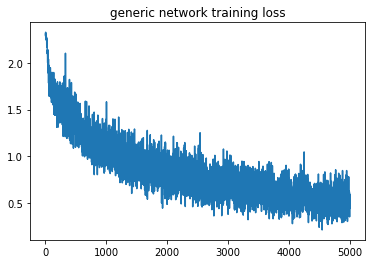

Accuracy: in validation 0.7559999823570251
The Current Loss by validation data: 0.7331407296050126
Iteration: 8 | Loss: 0.3402490019798279 | index 0 
Iteration: 8 | Loss: 0.34372273087501526 | index 100 
Iteration: 8 | Loss: 0.546241044998169 | index 200 
Iteration: 8 | Loss: 0.3460058569908142 | index 300 
Iteration: 8 | Loss: 0.3591221868991852 | index 400 
Iteration: 8 | Loss: 0.4500654637813568 | index 500 
Iteration: 8 | Loss: 0.576911449432373 | index 600 
Accuracy: in train 0.7107194662094116


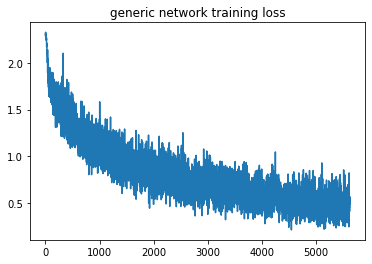

Accuracy: in validation 0.7458999752998352
The Current Loss by validation data: 0.7946238810089743
Iteration: 9 | Loss: 0.25449153780937195 | index 0 
Iteration: 9 | Loss: 0.23607628047466278 | index 100 
Iteration: 9 | Loss: 0.4512121081352234 | index 200 
Iteration: 9 | Loss: 0.4686068296432495 | index 300 
Iteration: 9 | Loss: 0.49041637778282166 | index 400 
Iteration: 9 | Loss: 0.3468140959739685 | index 500 
Iteration: 9 | Loss: 0.5244710445404053 | index 600 
Accuracy: in train 0.7245399951934814


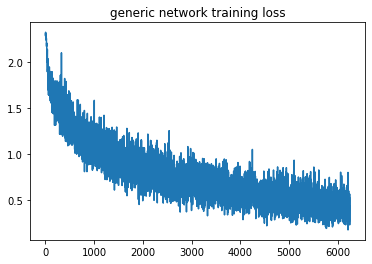

Accuracy: in validation 0.7626999616622925
The Current Loss by validation data: 0.7178358014222164
Iteration: 10 | Loss: 0.5622259378433228 | index 0 
Iteration: 10 | Loss: 0.34330564737319946 | index 100 
Iteration: 10 | Loss: 0.41391080617904663 | index 200 
Iteration: 10 | Loss: 0.43734633922576904 | index 300 
Iteration: 10 | Loss: 0.5270153880119324 | index 400 
Iteration: 10 | Loss: 0.5450389981269836 | index 500 
Iteration: 10 | Loss: 0.24578851461410522 | index 600 
Accuracy: in train 0.7370295524597168


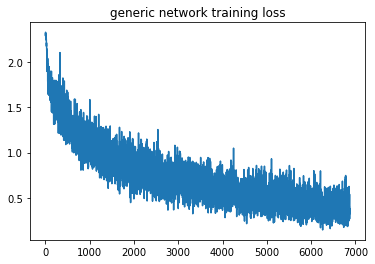

Accuracy: in validation 0.7676999568939209
The Current Loss by validation data: 0.7244363632171776
Iteration: 11 | Loss: 0.2689617872238159 | index 0 
Iteration: 11 | Loss: 0.326158344745636 | index 100 
Iteration: 11 | Loss: 0.30339980125427246 | index 200 
Iteration: 11 | Loss: 0.3339068591594696 | index 300 
Iteration: 11 | Loss: 0.38322651386260986 | index 400 
Iteration: 11 | Loss: 0.25918668508529663 | index 500 
Iteration: 11 | Loss: 0.4956153333187103 | index 600 
Accuracy: in train 0.7484041452407837


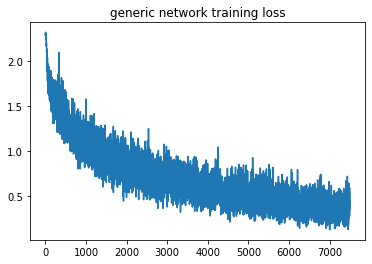

Accuracy: in validation 0.7656999826431274
The Current Loss by validation data: 0.7482091467471639
Iteration: 12 | Loss: 0.1572122573852539 | index 0 
Iteration: 12 | Loss: 0.17631369829177856 | index 100 
Iteration: 12 | Loss: 0.31833046674728394 | index 200 
Iteration: 12 | Loss: 0.3368320167064667 | index 300 
Iteration: 12 | Loss: 0.3418704569339752 | index 400 
Iteration: 12 | Loss: 0.3832814693450928 | index 500 
Iteration: 12 | Loss: 0.3190351128578186 | index 600 
Accuracy: in train 0.7588942646980286


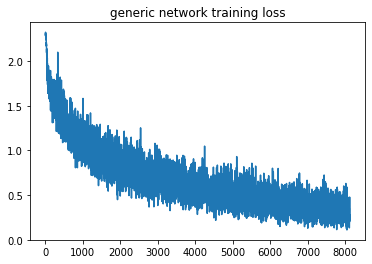

Accuracy: in validation 0.7831000089645386
The Current Loss by validation data: 0.6833645815302611
Iteration: 13 | Loss: 0.2966223657131195 | index 0 
Iteration: 13 | Loss: 0.20150266587734222 | index 100 
Iteration: 13 | Loss: 0.3560752868652344 | index 200 
Iteration: 13 | Loss: 0.25027215480804443 | index 300 
Iteration: 13 | Loss: 0.34243252873420715 | index 400 
Iteration: 13 | Loss: 0.2801034450531006 | index 500 
Iteration: 13 | Loss: 0.18806926906108856 | index 600 
Accuracy: in train 0.7685875296592712


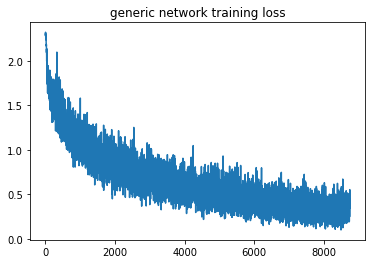

Accuracy: in validation 0.7556999921798706
The Current Loss by validation data: 0.8271212891028945
Iteration: 14 | Loss: 0.36695608496665955 | index 0 
Iteration: 14 | Loss: 0.24939528107643127 | index 100 
Iteration: 14 | Loss: 0.319343626499176 | index 200 
Iteration: 14 | Loss: 0.24950197339057922 | index 300 
Iteration: 14 | Loss: 0.16391003131866455 | index 400 
Iteration: 14 | Loss: 0.1742471158504486 | index 500 
Iteration: 14 | Loss: 0.44087710976600647 | index 600 
Accuracy: in train 0.7778433561325073


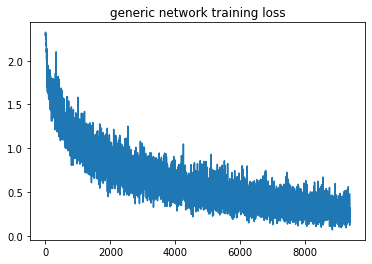

Accuracy: in validation 0.7700999975204468
The Current Loss by validation data: 0.7540995626692559
Iteration: 15 | Loss: 0.11832469701766968 | index 0 
Iteration: 15 | Loss: 0.13699182868003845 | index 100 
Iteration: 15 | Loss: 0.2712692618370056 | index 200 
Iteration: 15 | Loss: 0.3015017509460449 | index 300 
Iteration: 15 | Loss: 0.4337165355682373 | index 400 
Iteration: 15 | Loss: 0.3080889880657196 | index 500 
Iteration: 15 | Loss: 0.3187505304813385 | index 600 
Accuracy: in train 0.7862765192985535


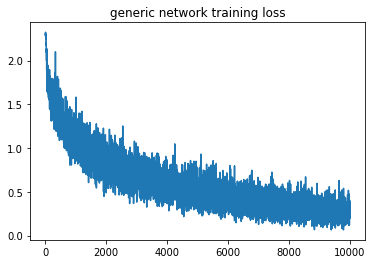

Accuracy: in validation 0.778499960899353
The Current Loss by validation data: 0.7788657923792578
Iteration: 16 | Loss: 0.20377208292484283 | index 0 
Iteration: 16 | Loss: 0.1872994601726532 | index 100 
Iteration: 16 | Loss: 0.1544225513935089 | index 200 
Iteration: 16 | Loss: 0.13547804951667786 | index 300 
Iteration: 16 | Loss: 0.30104538798332214 | index 400 
Iteration: 16 | Loss: 0.17039644718170166 | index 500 
Iteration: 16 | Loss: 0.17719313502311707 | index 600 
Accuracy: in train 0.7943220734596252


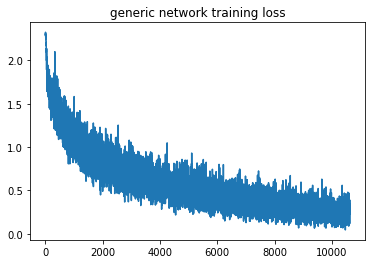

Accuracy: in validation 0.7872999906539917
The Current Loss by validation data: 0.723733078712111
Iteration: 17 | Loss: 0.14734499156475067 | index 0 
Iteration: 17 | Loss: 0.27292314171791077 | index 100 
Iteration: 17 | Loss: 0.14204999804496765 | index 200 
Iteration: 17 | Loss: 0.3159406781196594 | index 300 
Iteration: 17 | Loss: 0.308912992477417 | index 400 
Iteration: 17 | Loss: 0.1992514431476593 | index 500 
Iteration: 17 | Loss: 0.18101568520069122 | index 600 
Accuracy: in train 0.8018319606781006


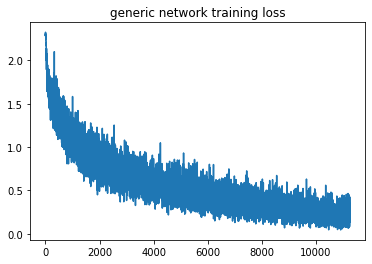

Accuracy: in validation 0.7770999670028687
The Current Loss by validation data: 0.7959608819074692
Iteration: 18 | Loss: 0.1670030951499939 | index 0 
Iteration: 18 | Loss: 0.15671265125274658 | index 100 
Iteration: 18 | Loss: 0.22145631909370422 | index 200 
Iteration: 18 | Loss: 0.1395106017589569 | index 300 
Iteration: 18 | Loss: 0.15315364301204681 | index 400 
Iteration: 18 | Loss: 0.16269032657146454 | index 500 
Iteration: 18 | Loss: 0.21406620740890503 | index 600 
Accuracy: in train 0.8089276552200317


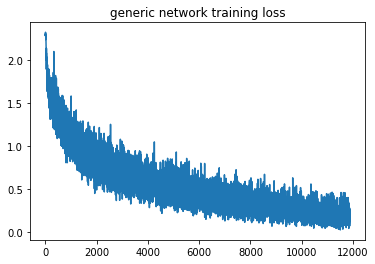

Accuracy: in validation 0.7902999520301819
The Current Loss by validation data: 0.7931817729192175
Iteration: 19 | Loss: 0.17059068381786346 | index 0 
Iteration: 19 | Loss: 0.17083878815174103 | index 100 
Iteration: 19 | Loss: 0.054520830512046814 | index 200 
Iteration: 19 | Loss: 0.12568265199661255 | index 300 
Iteration: 19 | Loss: 0.19770042598247528 | index 400 
Iteration: 19 | Loss: 0.07378913462162018 | index 500 
Iteration: 19 | Loss: 0.20650805532932281 | index 600 
Accuracy: in train 0.8155637383460999


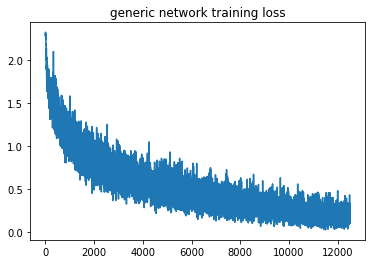

Accuracy: in validation 0.7943999767303467
The Current Loss by validation data: 0.7581812293286536
Iteration: 20 | Loss: 0.15398690104484558 | index 0 
Iteration: 20 | Loss: 0.15449455380439758 | index 100 
Iteration: 20 | Loss: 0.17461653053760529 | index 200 
Iteration: 20 | Loss: 0.24237234890460968 | index 300 
Iteration: 20 | Loss: 0.13417614996433258 | index 400 
Iteration: 20 | Loss: 0.22695165872573853 | index 500 
Iteration: 20 | Loss: 0.24372364580631256 | index 600 
Accuracy: in train 0.8217464089393616


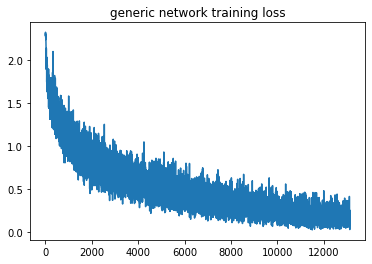

Accuracy: in validation 0.7856999635696411
The Current Loss by validation data: 0.8208583969219475
Iteration: 21 | Loss: 0.1718875914812088 | index 0 
Iteration: 21 | Loss: 0.14561760425567627 | index 100 
Iteration: 21 | Loss: 0.05957258492708206 | index 200 
Iteration: 21 | Loss: 0.13330920040607452 | index 300 
Iteration: 21 | Loss: 0.1336785852909088 | index 400 
Iteration: 21 | Loss: 0.15269970893859863 | index 500 
Iteration: 21 | Loss: 0.13478106260299683 | index 600 
Accuracy: in train 0.8275647759437561


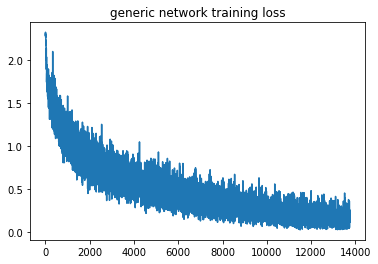

Accuracy: in validation 0.7847999930381775
The Current Loss by validation data: 0.8001727995219504
Iteration: 22 | Loss: 0.13329298794269562 | index 0 
Iteration: 22 | Loss: 0.11927385628223419 | index 100 
Iteration: 22 | Loss: 0.10816063731908798 | index 200 
Iteration: 22 | Loss: 0.125045046210289 | index 300 
Iteration: 22 | Loss: 0.0653894916176796 | index 400 
Iteration: 22 | Loss: 0.108881875872612 | index 500 
Iteration: 22 | Loss: 0.21199427545070648 | index 600 
Accuracy: in train 0.8330967426300049


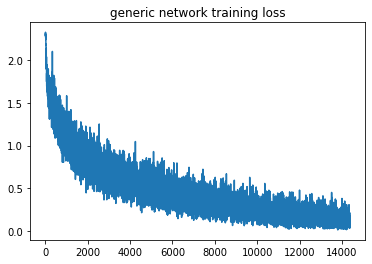

Accuracy: in validation 0.7942000031471252
The Current Loss by validation data: 0.8442909586581455
Iteration: 23 | Loss: 0.07639984786510468 | index 0 
Iteration: 23 | Loss: 0.09838031977415085 | index 100 
Iteration: 23 | Loss: 0.15604306757450104 | index 200 
Iteration: 23 | Loss: 0.17826633155345917 | index 300 
Iteration: 23 | Loss: 0.0797111988067627 | index 400 
Iteration: 23 | Loss: 0.11284439265727997 | index 500 
Iteration: 23 | Loss: 0.24129563570022583 | index 600 
Accuracy: in train 0.8382750153541565


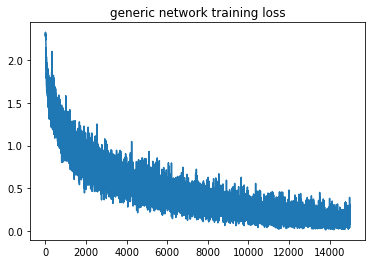

Accuracy: in validation 0.7605999708175659
The Current Loss by validation data: 1.0670005428563258
Iteration: 24 | Loss: 0.06404205411672592 | index 0 
Iteration: 24 | Loss: 0.08770845830440521 | index 100 
Iteration: 24 | Loss: 0.12327088415622711 | index 200 
Iteration: 24 | Loss: 0.11502864956855774 | index 300 
Iteration: 24 | Loss: 0.19585223495960236 | index 400 
Iteration: 24 | Loss: 0.0848119705915451 | index 500 
Iteration: 24 | Loss: 0.07358608394861221 | index 600 
Accuracy: in train 0.8431310057640076


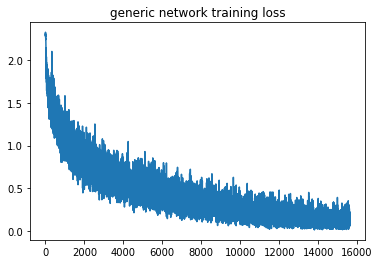

Accuracy: in validation 0.7936999797821045
The Current Loss by validation data: 0.8362975866551612
Iteration: 25 | Loss: 0.07403002679347992 | index 0 
Iteration: 25 | Loss: 0.03119286522269249 | index 100 
Iteration: 25 | Loss: 0.08643187582492828 | index 200 
Iteration: 25 | Loss: 0.04874098673462868 | index 300 
Iteration: 25 | Loss: 0.14062194526195526 | index 400 
Iteration: 25 | Loss: 0.14488713443279266 | index 500 
Iteration: 25 | Loss: 0.06564769148826599 | index 600 
Accuracy: in train 0.8477519750595093


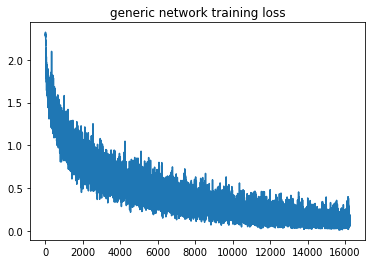

Accuracy: in validation 0.8021999597549438
The Current Loss by validation data: 0.8156547897560581
Iteration: 26 | Loss: 0.11240452527999878 | index 0 
Iteration: 26 | Loss: 0.0688343420624733 | index 100 
Iteration: 26 | Loss: 0.06820251047611237 | index 200 
Iteration: 26 | Loss: 0.06185952201485634 | index 300 
Iteration: 26 | Loss: 0.18850082159042358 | index 400 
Iteration: 26 | Loss: 0.07916416227817535 | index 500 
Iteration: 26 | Loss: 0.06683953106403351 | index 600 
Accuracy: in train 0.8521555662155151


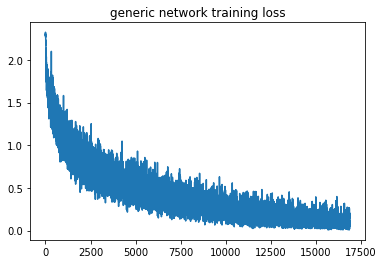

Accuracy: in validation 0.7976999878883362
The Current Loss by validation data: 0.8777769059891913
Iteration: 27 | Loss: 0.13889753818511963 | index 0 
Iteration: 27 | Loss: 0.10780095309019089 | index 100 
Iteration: 27 | Loss: 0.097322016954422 | index 200 
Iteration: 27 | Loss: 0.19565105438232422 | index 300 
Iteration: 27 | Loss: 0.11974328011274338 | index 400 
Iteration: 27 | Loss: 0.07702050358057022 | index 500 
Iteration: 27 | Loss: 0.10264740139245987 | index 600 
Accuracy: in train 0.8562348484992981


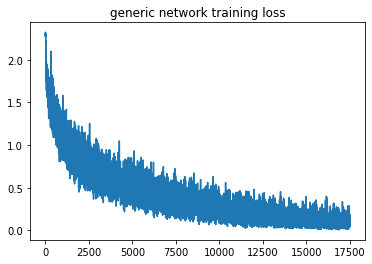

Accuracy: in validation 0.7896999716758728
The Current Loss by validation data: 0.9280106558161936
Iteration: 28 | Loss: 0.04302801191806793 | index 0 
Iteration: 28 | Loss: 0.08239758759737015 | index 100 
Iteration: 28 | Loss: 0.1174478530883789 | index 200 
Iteration: 28 | Loss: 0.09813389182090759 | index 300 
Iteration: 28 | Loss: 0.04839722812175751 | index 400 
Iteration: 28 | Loss: 0.03284579515457153 | index 500 
Iteration: 28 | Loss: 0.12424351274967194 | index 600 
Accuracy: in train 0.8601008653640747


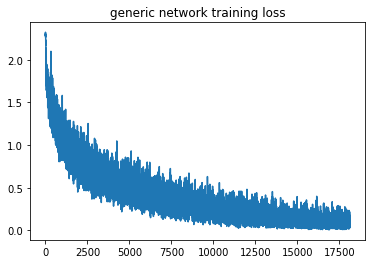

Accuracy: in validation 0.7793999910354614
The Current Loss by validation data: 1.0334444831890666
Iteration: 29 | Loss: 0.018353478983044624 | index 0 
Iteration: 29 | Loss: 0.05474871024489403 | index 100 
Iteration: 29 | Loss: 0.08222010731697083 | index 200 
Iteration: 29 | Loss: 0.15350016951560974 | index 300 
Iteration: 29 | Loss: 0.05986017733812332 | index 400 
Iteration: 29 | Loss: 0.05965100973844528 | index 500 
Iteration: 29 | Loss: 0.07779046893119812 | index 600 
Accuracy: in train 0.8637325167655945


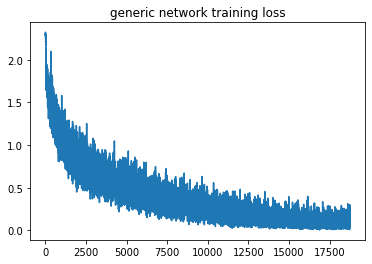

Accuracy: in validation 0.7913999557495117
The Current Loss by validation data: 0.9533216079139406
Iteration: 30 | Loss: 0.1518581509590149 | index 0 
Iteration: 30 | Loss: 0.06945137679576874 | index 100 
Iteration: 30 | Loss: 0.0587429516017437 | index 200 
Iteration: 30 | Loss: 0.059090085327625275 | index 300 
Iteration: 30 | Loss: 0.05497005581855774 | index 400 
Iteration: 30 | Loss: 0.1412576586008072 | index 500 
Iteration: 30 | Loss: 0.08936317265033722 | index 600 
Accuracy: in train 0.8672661185264587


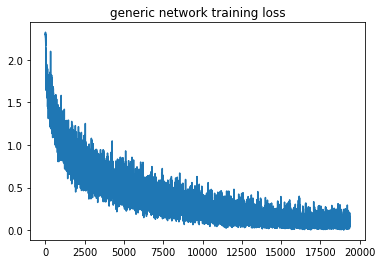

Accuracy: in validation 0.795699954032898
The Current Loss by validation data: 0.9305470614296616
Iteration: 31 | Loss: 0.03805651143193245 | index 0 
Iteration: 31 | Loss: 0.22287070751190186 | index 100 
Iteration: 31 | Loss: 0.033515218645334244 | index 200 
Iteration: 31 | Loss: 0.02299145609140396 | index 300 
Iteration: 31 | Loss: 0.0478910394012928 | index 400 
Iteration: 31 | Loss: 0.025831935927271843 | index 500 
Iteration: 31 | Loss: 0.03751257807016373 | index 600 
Accuracy: in train 0.8705398440361023


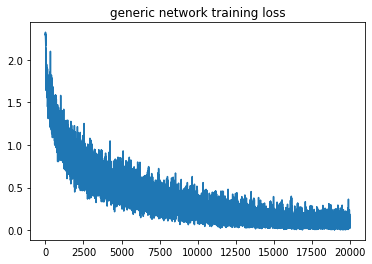

Accuracy: in validation 0.7833999991416931
The Current Loss by validation data: 0.9825535849401146
Iteration: 32 | Loss: 0.1280565857887268 | index 0 
Iteration: 32 | Loss: 0.037088941782712936 | index 100 
Iteration: 32 | Loss: 0.06351447850465775 | index 200 
Iteration: 32 | Loss: 0.09564682841300964 | index 300 
Iteration: 32 | Loss: 0.04909377545118332 | index 400 
Iteration: 32 | Loss: 0.08201173692941666 | index 500 
Iteration: 32 | Loss: 0.06204155832529068 | index 600 
Accuracy: in train 0.8736992478370667


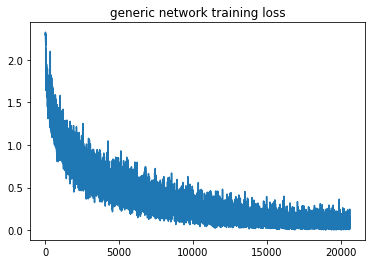

Accuracy: in validation 0.7971999645233154
The Current Loss by validation data: 0.9857823896180292
Iteration: 33 | Loss: 0.05037843808531761 | index 0 
Iteration: 33 | Loss: 0.01801281049847603 | index 100 
Iteration: 33 | Loss: 0.053065598011016846 | index 200 
Iteration: 33 | Loss: 0.09852822870016098 | index 300 
Iteration: 33 | Loss: 0.45437151193618774 | index 400 
Iteration: 33 | Loss: 0.2141132801771164 | index 500 
Iteration: 33 | Loss: 0.05429678410291672 | index 600 
Accuracy: in train 0.8767102956771851


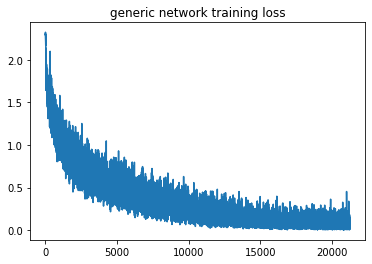

Accuracy: in validation 0.7961999773979187
The Current Loss by validation data: 0.9325084574283309
Iteration: 34 | Loss: 0.18111129105091095 | index 0 
Iteration: 34 | Loss: 0.07425129413604736 | index 100 
Iteration: 34 | Loss: 0.040715012699365616 | index 200 
Iteration: 34 | Loss: 0.04446536302566528 | index 300 
Iteration: 34 | Loss: 0.07828439027070999 | index 400 
Iteration: 34 | Loss: 0.0384686253964901 | index 500 
Iteration: 34 | Loss: 0.03327006474137306 | index 600 
Accuracy: in train 0.8795321583747864


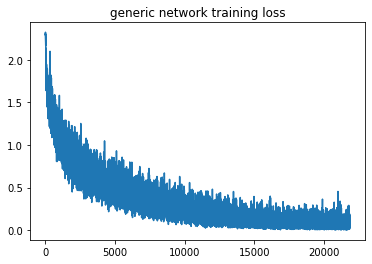

Accuracy: in validation 0.7931999564170837
The Current Loss by validation data: 0.9389745879704785
Iteration: 35 | Loss: 0.01840163581073284 | index 0 
Iteration: 35 | Loss: 0.06028670817613602 | index 100 
Iteration: 35 | Loss: 0.01865074411034584 | index 200 
Iteration: 35 | Loss: 0.034133944660425186 | index 300 
Iteration: 35 | Loss: 0.08542840927839279 | index 400 
Iteration: 35 | Loss: 0.08893737196922302 | index 500 
Iteration: 35 | Loss: 0.018524741753935814 | index 600 
Accuracy: in train 0.8822298645973206


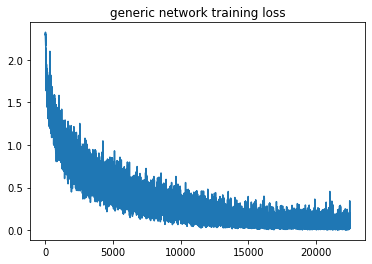

Accuracy: in validation 0.7828999757766724
The Current Loss by validation data: 1.0431869451407414
Iteration: 36 | Loss: 0.056788135319948196 | index 0 
Iteration: 36 | Loss: 0.009319942444562912 | index 100 
Iteration: 36 | Loss: 0.015352106653153896 | index 200 
Iteration: 36 | Loss: 0.011755181476473808 | index 300 
Iteration: 36 | Loss: 0.0937890037894249 | index 400 
Iteration: 36 | Loss: 0.042243510484695435 | index 500 
Iteration: 36 | Loss: 0.033044103533029556 | index 600 
Accuracy: in train 0.8847614526748657


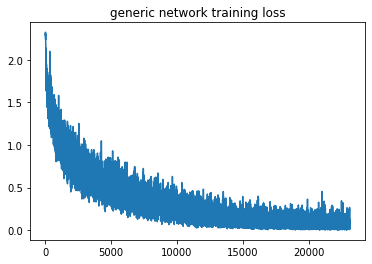

Accuracy: in validation 0.7929999828338623
The Current Loss by validation data: 0.9364451688186378
Iteration: 37 | Loss: 0.04298815876245499 | index 0 
Iteration: 37 | Loss: 0.02232504077255726 | index 100 
Iteration: 37 | Loss: 0.12701474130153656 | index 200 
Iteration: 37 | Loss: 0.06686372309923172 | index 300 
Iteration: 37 | Loss: 0.040750641375780106 | index 400 
Iteration: 37 | Loss: 0.0737624317407608 | index 500 
Iteration: 37 | Loss: 0.04247765615582466 | index 600 
Accuracy: in train 0.8872612118721008


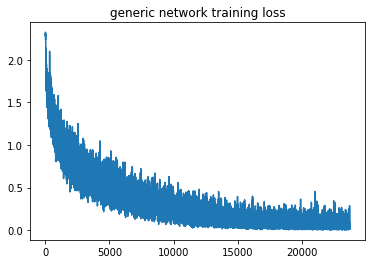

Accuracy: in validation 0.8001999855041504
The Current Loss by validation data: 0.940641640477879
Iteration: 38 | Loss: 0.07214921712875366 | index 0 
Iteration: 38 | Loss: 0.06679467111825943 | index 100 
Iteration: 38 | Loss: 0.13975590467453003 | index 200 
Iteration: 38 | Loss: 0.10927995294332504 | index 300 
Iteration: 38 | Loss: 0.10501489043235779 | index 400 
Iteration: 38 | Loss: 0.14249300956726074 | index 500 
Iteration: 38 | Loss: 0.026619497686624527 | index 600 
Accuracy: in train 0.8896384239196777


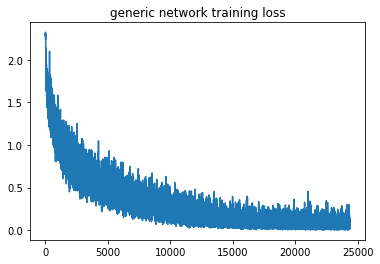

Accuracy: in validation 0.786899983882904
The Current Loss by validation data: 1.0308665144405547
Iteration: 39 | Loss: 0.005102621857076883 | index 0 
Iteration: 39 | Loss: 0.017302772030234337 | index 100 
Iteration: 39 | Loss: 0.03651724383234978 | index 200 
Iteration: 39 | Loss: 0.12618161737918854 | index 300 
Iteration: 39 | Loss: 0.09348456561565399 | index 400 
Iteration: 39 | Loss: 0.030062885954976082 | index 500 
Iteration: 39 | Loss: 0.21341493725776672 | index 600 
Accuracy: in train 0.8918405771255493


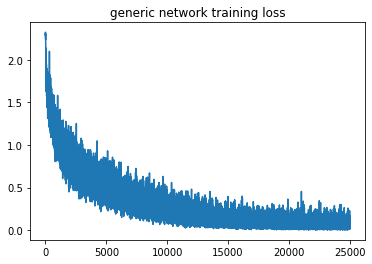

Accuracy: in validation 0.792199969291687
The Current Loss by validation data: 0.9919315483539727
Iteration: 40 | Loss: 0.06229206919670105 | index 0 
Iteration: 40 | Loss: 0.025533147156238556 | index 100 
Iteration: 40 | Loss: 0.04753142222762108 | index 200 
Iteration: 40 | Loss: 0.013963400386273861 | index 300 
Iteration: 40 | Loss: 0.03804603964090347 | index 400 
Iteration: 40 | Loss: 0.04002154618501663 | index 500 
Iteration: 40 | Loss: 0.029971927404403687 | index 600 
Accuracy: in train 0.8939805030822754


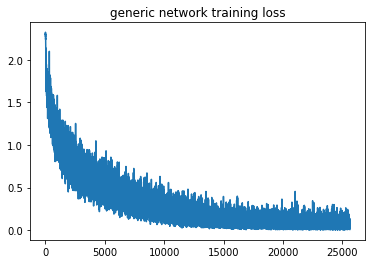

Accuracy: in validation 0.7911999821662903
The Current Loss by validation data: 1.0044535521868687
Iteration: 41 | Loss: 0.08347167819738388 | index 0 
Iteration: 41 | Loss: 0.04138294607400894 | index 100 
Iteration: 41 | Loss: 0.13206852972507477 | index 200 
Iteration: 41 | Loss: 0.017539747059345245 | index 300 
Iteration: 41 | Loss: 0.03058929741382599 | index 400 
Iteration: 41 | Loss: 0.04653087258338928 | index 500 
Iteration: 41 | Loss: 0.039590515196323395 | index 600 
Accuracy: in train 0.8960362672805786


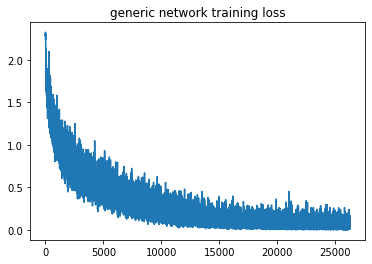

Accuracy: in validation 0.786799967288971
The Current Loss by validation data: 1.0936382915943292
Iteration: 42 | Loss: 0.10472207516431808 | index 0 
Iteration: 42 | Loss: 0.040861811488866806 | index 100 
Iteration: 42 | Loss: 0.10627751797437668 | index 200 
Iteration: 42 | Loss: 0.07719199359416962 | index 300 
Iteration: 42 | Loss: 0.03933383524417877 | index 400 
Iteration: 42 | Loss: 0.14150969684123993 | index 500 
Iteration: 42 | Loss: 0.0055587454698979855 | index 600 
Accuracy: in train 0.898038923740387


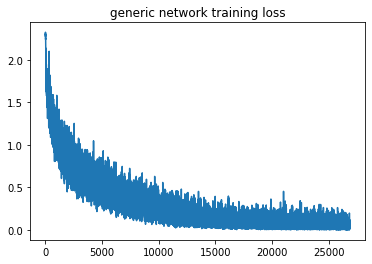

Accuracy: in validation 0.7930999994277954
The Current Loss by validation data: 1.0115898179400498
Iteration: 43 | Loss: 0.05522313714027405 | index 0 
Iteration: 43 | Loss: 0.11056457459926605 | index 100 
Iteration: 43 | Loss: 0.020871737971901894 | index 200 
Iteration: 43 | Loss: 0.05200205743312836 | index 300 
Iteration: 43 | Loss: 0.09488975256681442 | index 400 
Iteration: 43 | Loss: 0.05688043683767319 | index 500 
Iteration: 43 | Loss: 0.09021793305873871 | index 600 
Accuracy: in train 0.8999550938606262


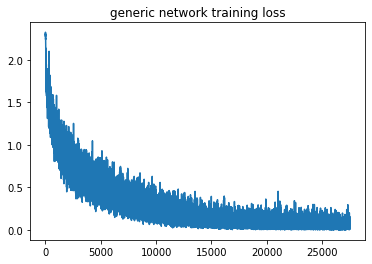

Accuracy: in validation 0.791700005531311
The Current Loss by validation data: 1.0096071225822352
Iteration: 44 | Loss: 0.06618967652320862 | index 0 
Iteration: 44 | Loss: 0.027377992868423462 | index 100 
Iteration: 44 | Loss: 0.0077127087861299515 | index 200 
Iteration: 44 | Loss: 0.02655506134033203 | index 300 
Iteration: 44 | Loss: 0.11356060206890106 | index 400 
Iteration: 44 | Loss: 0.03130316734313965 | index 500 
Iteration: 44 | Loss: 0.04692676663398743 | index 600 
Accuracy: in train 0.9017661213874817


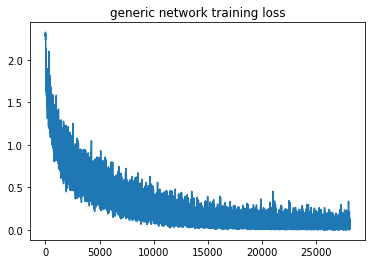

Accuracy: in validation 0.7953999638557434
The Current Loss by validation data: 1.0143844853540895
Iteration: 45 | Loss: 0.01887536235153675 | index 0 
Iteration: 45 | Loss: 0.057008713483810425 | index 100 
Iteration: 45 | Loss: 0.14869867265224457 | index 200 
Iteration: 45 | Loss: 0.20895451307296753 | index 300 
Iteration: 45 | Loss: 0.04667990282177925 | index 400 
Iteration: 45 | Loss: 0.04363243654370308 | index 500 
Iteration: 45 | Loss: 0.06501162797212601 | index 600 
Accuracy: in train 0.9035272002220154


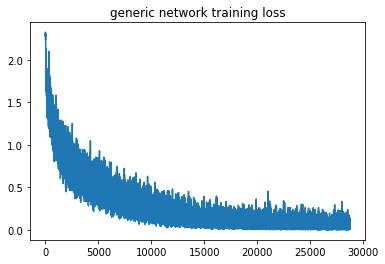

Accuracy: in validation 0.7960999608039856
The Current Loss by validation data: 1.0177091857430283
Iteration: 46 | Loss: 0.013922009617090225 | index 0 
Iteration: 46 | Loss: 0.08128450065851212 | index 100 
Iteration: 46 | Loss: 0.0073631261475384235 | index 200 
Iteration: 46 | Loss: 0.18884429335594177 | index 300 
Iteration: 46 | Loss: 0.011659709736704826 | index 400 
Iteration: 46 | Loss: 0.10045405477285385 | index 500 
Iteration: 46 | Loss: 0.011495308950543404 | index 600 
Accuracy: in train 0.9051691889762878


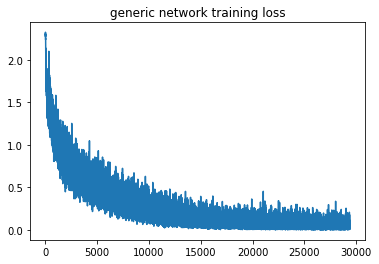

Accuracy: in validation 0.786799967288971
The Current Loss by validation data: 1.106935048179262
Iteration: 47 | Loss: 0.04189145565032959 | index 0 
Iteration: 47 | Loss: 0.006403154227882624 | index 100 
Iteration: 47 | Loss: 0.004665156360715628 | index 200 
Iteration: 47 | Loss: 0.12615522742271423 | index 300 
Iteration: 47 | Loss: 0.06008312106132507 | index 400 
Iteration: 47 | Loss: 0.0699872076511383 | index 500 
Iteration: 47 | Loss: 0.038602303713560104 | index 600 
Accuracy: in train 0.9067760705947876


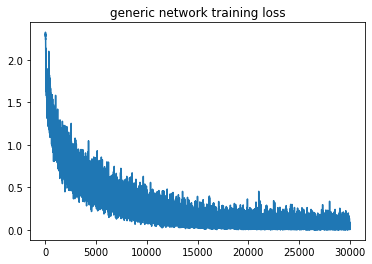

Accuracy: in validation 0.7949999570846558
The Current Loss by validation data: 0.9847715941204387
Iteration: 48 | Loss: 0.028604280203580856 | index 0 
Iteration: 48 | Loss: 0.05434240400791168 | index 100 
Iteration: 48 | Loss: 0.13557536900043488 | index 200 
Iteration: 48 | Loss: 0.0818372443318367 | index 300 
Iteration: 48 | Loss: 0.028591269627213478 | index 400 
Iteration: 48 | Loss: 0.02350710891187191 | index 500 
Iteration: 48 | Loss: 0.009351501241326332 | index 600 
Accuracy: in train 0.9083142876625061


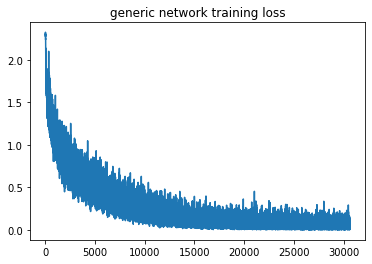

Accuracy: in validation 0.8000999689102173
The Current Loss by validation data: 0.9535508556350781
Iteration: 49 | Loss: 0.04368722438812256 | index 0 
Iteration: 49 | Loss: 0.05608687922358513 | index 100 
Iteration: 49 | Loss: 0.008652999997138977 | index 200 
Iteration: 49 | Loss: 0.020146580412983894 | index 300 
Iteration: 49 | Loss: 0.07183980196714401 | index 400 
Iteration: 49 | Loss: 0.008330963551998138 | index 500 
Iteration: 49 | Loss: 0.08881383389234543 | index 600 
Accuracy: in train 0.9098324775695801


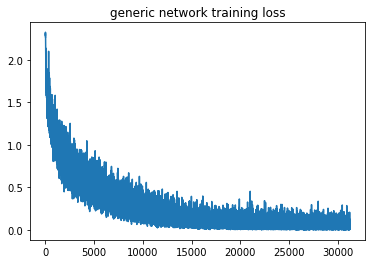

Accuracy: in validation 0.8026999831199646
The Current Loss by validation data: 0.9751804055302007
Iteration: 50 | Loss: 0.09110460430383682 | index 0 
Iteration: 50 | Loss: 0.030506964772939682 | index 100 
Iteration: 50 | Loss: 0.13702741265296936 | index 200 
Iteration: 50 | Loss: 0.034092243760824203 | index 300 
Iteration: 50 | Loss: 0.01798345521092415 | index 400 
Iteration: 50 | Loss: 0.22497063875198364 | index 500 
Iteration: 50 | Loss: 0.08862115442752838 | index 600 
Accuracy: in train 0.9112780094146729


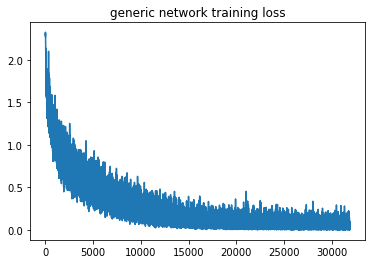

Accuracy: in validation 0.8075000047683716
The Current Loss by validation data: 0.9491498588946214
Iteration: 51 | Loss: 0.009051577188074589 | index 0 
Iteration: 51 | Loss: 0.009049623273313046 | index 100 
Iteration: 51 | Loss: 0.07097204774618149 | index 200 
Iteration: 51 | Loss: 0.17573198676109314 | index 300 
Iteration: 51 | Loss: 0.08441749215126038 | index 400 
Iteration: 51 | Loss: 0.03263461962342262 | index 500 
Iteration: 51 | Loss: 0.0660770907998085 | index 600 
Accuracy: in train 0.9127029180526733


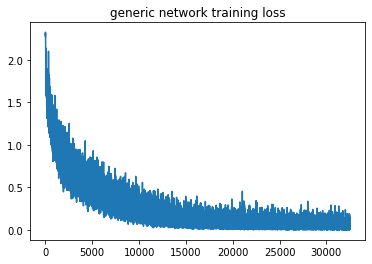

Accuracy: in validation 0.8008999824523926
The Current Loss by validation data: 1.018563974055515
Iteration: 52 | Loss: 0.06809312105178833 | index 0 
Iteration: 52 | Loss: 0.06322461366653442 | index 100 
Iteration: 52 | Loss: 0.017285434529185295 | index 200 
Iteration: 52 | Loss: 0.027437599375844002 | index 300 
Iteration: 52 | Loss: 0.01477674301713705 | index 400 
Iteration: 52 | Loss: 0.00538143003359437 | index 500 
Iteration: 52 | Loss: 0.08511828631162643 | index 600 
Accuracy: in train 0.9140712022781372


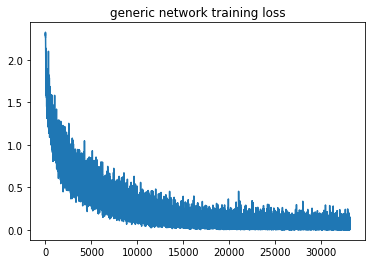

Accuracy: in validation 0.7991999983787537
The Current Loss by validation data: 0.9405632150021328
Iteration: 53 | Loss: 0.0632610023021698 | index 0 
Iteration: 53 | Loss: 0.0027195208240300417 | index 100 
Iteration: 53 | Loss: 0.044415611773729324 | index 200 
Iteration: 53 | Loss: 0.014102719724178314 | index 300 
Iteration: 53 | Loss: 0.107383593916893 | index 400 
Iteration: 53 | Loss: 0.02208886668086052 | index 500 
Iteration: 53 | Loss: 0.07782846689224243 | index 600 
Accuracy: in train 0.9153754711151123


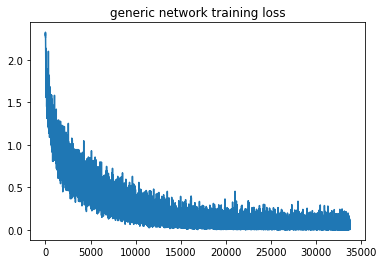

Accuracy: in validation 0.7973999977111816
The Current Loss by validation data: 1.0155411922627953
Iteration: 54 | Loss: 0.0094519704580307 | index 0 
Iteration: 54 | Loss: 0.03291071578860283 | index 100 
Iteration: 54 | Loss: 0.036129266023635864 | index 200 
Iteration: 54 | Loss: 0.030866118147969246 | index 300 
Iteration: 54 | Loss: 0.0321386381983757 | index 400 
Iteration: 54 | Loss: 0.03765909746289253 | index 500 
Iteration: 54 | Loss: 0.037445470690727234 | index 600 
Accuracy: in train 0.9166454076766968


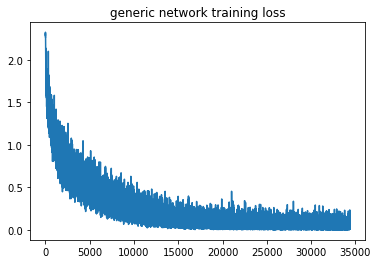

Accuracy: in validation 0.7842999696731567
The Current Loss by validation data: 1.1681769116289298
Iteration: 55 | Loss: 0.057144083082675934 | index 0 
Iteration: 55 | Loss: 0.00281039671972394 | index 100 
Iteration: 55 | Loss: 0.054523542523384094 | index 200 
Iteration: 55 | Loss: 0.010202892124652863 | index 300 
Iteration: 55 | Loss: 0.026875201612710953 | index 400 
Iteration: 55 | Loss: 0.03702991083264351 | index 500 
Iteration: 55 | Loss: 0.04453648254275322 | index 600 
Accuracy: in train 0.9178763628005981


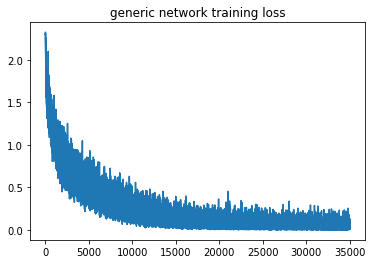

Accuracy: in validation 0.8032999634742737
The Current Loss by validation data: 0.9675184537650673
Iteration: 56 | Loss: 0.07635442912578583 | index 0 
Iteration: 56 | Loss: 0.022582314908504486 | index 100 
Iteration: 56 | Loss: 0.08087896555662155 | index 200 
Iteration: 56 | Loss: 0.008873014710843563 | index 300 
Iteration: 56 | Loss: 0.018990585580468178 | index 400 
Iteration: 56 | Loss: 0.014888881705701351 | index 500 
Iteration: 56 | Loss: 0.016460247337818146 | index 600 
Accuracy: in train 0.9190495610237122


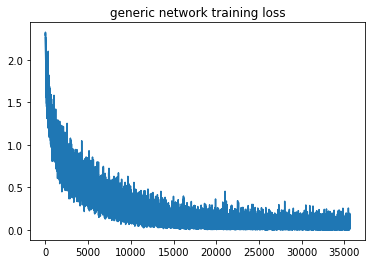

Accuracy: in validation 0.8014999628067017
The Current Loss by validation data: 0.9999476893312612
Iteration: 57 | Loss: 0.014704554341733456 | index 0 
Iteration: 57 | Loss: 0.03573265299201012 | index 100 
Iteration: 57 | Loss: 0.003760057967156172 | index 200 
Iteration: 57 | Loss: 0.007809102535247803 | index 300 
Iteration: 57 | Loss: 0.011751893907785416 | index 400 
Iteration: 57 | Loss: 0.0698782280087471 | index 500 
Iteration: 57 | Loss: 0.03731729835271835 | index 600 
Accuracy: in train 0.9202060699462891


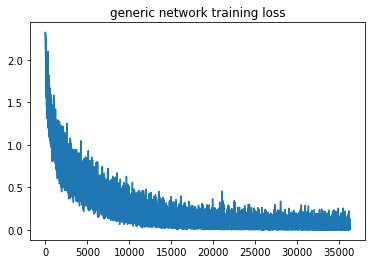

Accuracy: in validation 0.800599992275238
The Current Loss by validation data: 0.9914428312687358
Iteration: 58 | Loss: 0.08341053873300552 | index 0 
Iteration: 58 | Loss: 0.05701267719268799 | index 100 
Iteration: 58 | Loss: 0.008328810334205627 | index 200 
Iteration: 58 | Loss: 0.016289057210087776 | index 300 
Iteration: 58 | Loss: 0.06268038600683212 | index 400 
Iteration: 58 | Loss: 0.02039216086268425 | index 500 
Iteration: 58 | Loss: 0.056249093264341354 | index 600 
Accuracy: in train 0.9213186502456665


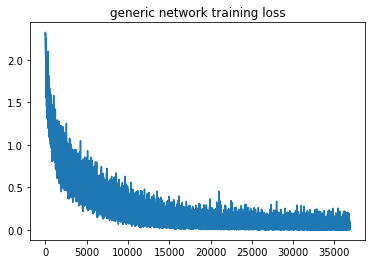

Accuracy: in validation 0.7931999564170837
The Current Loss by validation data: 1.0908845621309462
Iteration: 59 | Loss: 0.008288989774882793 | index 0 
Iteration: 59 | Loss: 0.05007516220211983 | index 100 
Iteration: 59 | Loss: 0.043191928416490555 | index 200 
Iteration: 59 | Loss: 0.02198101580142975 | index 300 
Iteration: 59 | Loss: 0.06027502194046974 | index 400 
Iteration: 59 | Loss: 0.05323725566267967 | index 500 
Iteration: 59 | Loss: 0.013167161494493484 | index 600 
Accuracy: in train 0.9223970770835876


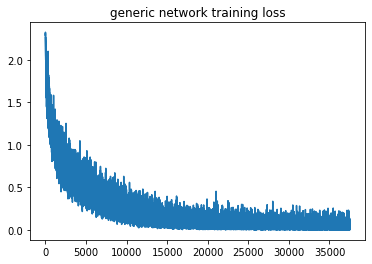

Accuracy: in validation 0.7998999953269958
The Current Loss by validation data: 1.0330842898529806
Iteration: 60 | Loss: 0.010109947063028812 | index 0 
Iteration: 60 | Loss: 0.017337121069431305 | index 100 
Iteration: 60 | Loss: 0.008785219863057137 | index 200 
Iteration: 60 | Loss: 0.03256716579198837 | index 300 
Iteration: 60 | Loss: 0.10077300667762756 | index 400 
Iteration: 60 | Loss: 0.04867037013173103 | index 500 
Iteration: 60 | Loss: 0.13412396609783173 | index 600 
Accuracy: in train 0.9234398007392883


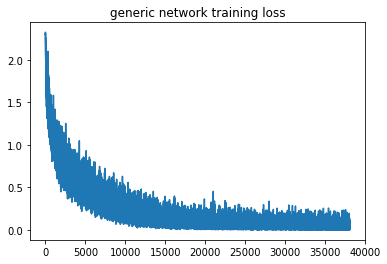

Accuracy: in validation 0.7893999814987183
The Current Loss by validation data: 1.0461490644011529
Iteration: 61 | Loss: 0.007891451008617878 | index 0 
Iteration: 61 | Loss: 0.08274074643850327 | index 100 
Iteration: 61 | Loss: 0.057796359062194824 | index 200 
Iteration: 61 | Loss: 0.03974161669611931 | index 300 
Iteration: 61 | Loss: 0.015364842489361763 | index 400 
Iteration: 61 | Loss: 0.039816271513700485 | index 500 
Iteration: 61 | Loss: 0.08435647189617157 | index 600 
Accuracy: in train 0.9244693517684937


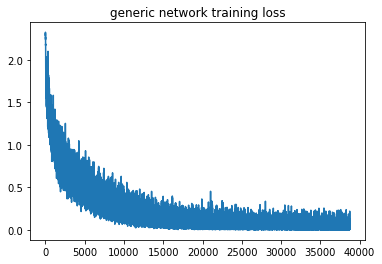

Accuracy: in validation 0.8044999837875366
The Current Loss by validation data: 0.9698816256917966
Iteration: 62 | Loss: 0.013421298004686832 | index 0 
Iteration: 62 | Loss: 0.10176897048950195 | index 100 
Iteration: 62 | Loss: 0.06733228266239166 | index 200 
Iteration: 62 | Loss: 0.008211920969188213 | index 300 
Iteration: 62 | Loss: 0.03753054141998291 | index 400 
Iteration: 62 | Loss: 0.13495968282222748 | index 500 
Iteration: 62 | Loss: 0.021791042760014534 | index 600 
Accuracy: in train 0.925463855266571


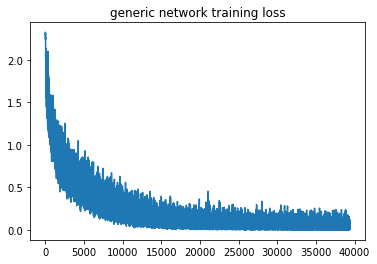

Accuracy: in validation 0.790399968624115
The Current Loss by validation data: 1.1062519630049443
Iteration: 63 | Loss: 0.023536503314971924 | index 0 
Iteration: 63 | Loss: 0.02477269619703293 | index 100 
Iteration: 63 | Loss: 0.013939356431365013 | index 200 
Iteration: 63 | Loss: 0.004552457481622696 | index 300 
Iteration: 63 | Loss: 0.011635605245828629 | index 400 
Iteration: 63 | Loss: 0.004398013930767775 | index 500 
Iteration: 63 | Loss: 0.007216149941086769 | index 600 
Accuracy: in train 0.9264273047447205


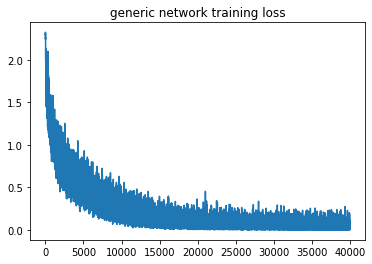

Accuracy: in validation 0.7928999662399292
The Current Loss by validation data: 1.0690476691267292
Iteration: 64 | Loss: 0.023510335013270378 | index 0 
Iteration: 64 | Loss: 0.02662046253681183 | index 100 
Iteration: 64 | Loss: 0.04010724648833275 | index 200 
Iteration: 64 | Loss: 0.022958209738135338 | index 300 
Iteration: 64 | Loss: 0.11869973689317703 | index 400 
Iteration: 64 | Loss: 0.019460462033748627 | index 500 
Iteration: 64 | Loss: 0.017382623627781868 | index 600 
Accuracy: in train 0.9273646473884583


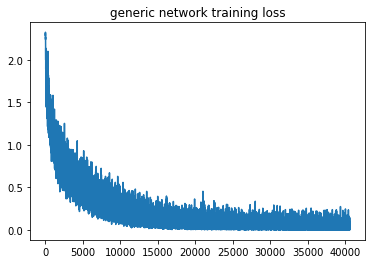

Accuracy: in validation 0.8089999556541443
The Current Loss by validation data: 1.0107263780323563
Iteration: 65 | Loss: 0.020225724205374718 | index 0 
Iteration: 65 | Loss: 0.058440301567316055 | index 100 
Iteration: 65 | Loss: 0.023673804476857185 | index 200 
Iteration: 65 | Loss: 0.008742909878492355 | index 300 
Iteration: 65 | Loss: 0.10299655795097351 | index 400 
Iteration: 65 | Loss: 0.010853298008441925 | index 500 
Iteration: 65 | Loss: 0.011834662407636642 | index 600 
Accuracy: in train 0.9282788038253784


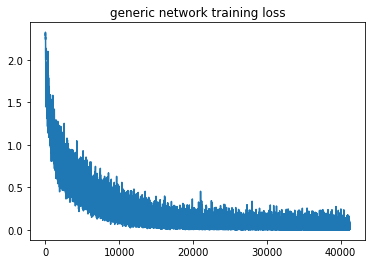

Accuracy: in validation 0.7999999523162842
The Current Loss by validation data: 1.0394802966694923
Iteration: 66 | Loss: 0.020811790600419044 | index 0 
Iteration: 66 | Loss: 0.004372338764369488 | index 100 
Iteration: 66 | Loss: 0.02031206153333187 | index 200 
Iteration: 66 | Loss: 0.06680246442556381 | index 300 
Iteration: 66 | Loss: 0.010920349508523941 | index 400 
Iteration: 66 | Loss: 0.013329459354281425 | index 500 
Iteration: 66 | Loss: 0.06615204364061356 | index 600 
Accuracy: in train 0.9291760921478271


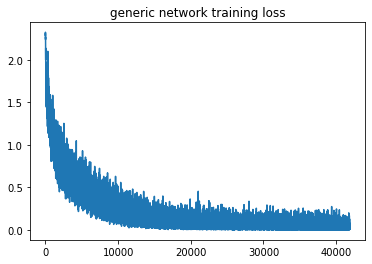

Accuracy: in validation 0.7991999983787537
The Current Loss by validation data: 1.0598158092255805
Iteration: 67 | Loss: 0.11547861993312836 | index 0 
Iteration: 67 | Loss: 0.023999584838747978 | index 100 
Iteration: 67 | Loss: 0.038824789226055145 | index 200 
Iteration: 67 | Loss: 0.042841587215662 | index 300 
Iteration: 67 | Loss: 0.007104797288775444 | index 400 
Iteration: 67 | Loss: 0.10665447264909744 | index 500 
Iteration: 67 | Loss: 0.06341277062892914 | index 600 
Accuracy: in train 0.9300161600112915


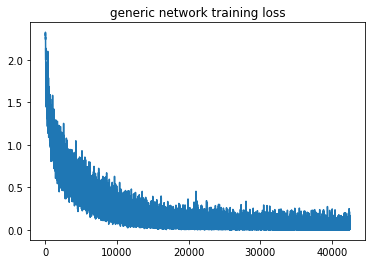

Accuracy: in validation 0.8060999512672424
The Current Loss by validation data: 0.8933980180199739
Iteration: 68 | Loss: 0.01946371980011463 | index 0 
Iteration: 68 | Loss: 0.005102058872580528 | index 100 
Iteration: 68 | Loss: 0.05427538976073265 | index 200 
Iteration: 68 | Loss: 0.02884451486170292 | index 300 
Iteration: 68 | Loss: 0.08265466243028641 | index 400 
Iteration: 68 | Loss: 0.004373024217784405 | index 500 
Iteration: 68 | Loss: 0.03025558963418007 | index 600 
Accuracy: in train 0.9308764338493347


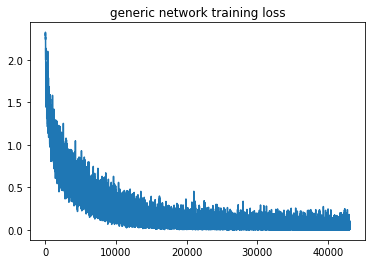

Accuracy: in validation 0.8083999752998352
The Current Loss by validation data: 0.9958501215193681
Iteration: 69 | Loss: 0.026942741125822067 | index 0 
Iteration: 69 | Loss: 0.020074179396033287 | index 100 
Iteration: 69 | Loss: 0.09095732867717743 | index 200 
Iteration: 69 | Loss: 0.013934397138655186 | index 300 
Iteration: 69 | Loss: 0.027187826111912727 | index 400 
Iteration: 69 | Loss: 0.04280414804816246 | index 500 
Iteration: 69 | Loss: 0.050307631492614746 | index 600 
Accuracy: in train 0.931682825088501


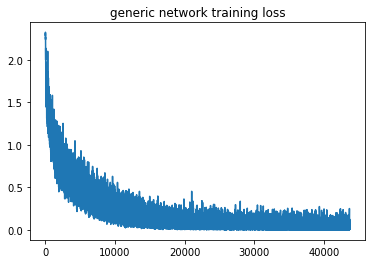

Accuracy: in validation 0.796999990940094
The Current Loss by validation data: 1.035289013461702


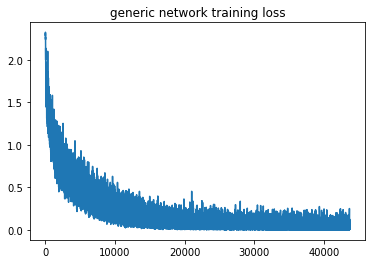

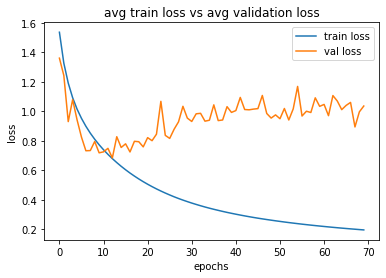

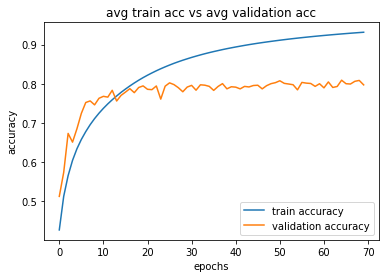

Accuracy: in test 0.8093000054359436
Accuracy under fgsm attack 0.0354
Accuracy under fgsm attack 0.0515


In [ ]:
from torch._C import NoneType
import torch
import torchvision
import torchvision.datasets as datasets
from torch import optim
from torchvision import transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as data
from torchsummary import summary

import copy
from PIL import Image
from scipy import ndimage


def load_dataset():
    transform_train = transforms.Compose([
        # agmentation below
        transforms.RandomCrop(32, padding=4), 
        transforms.RandomHorizontalFlip(),
        # regular normalization
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ])

    # Normalize the test set same as training set without augmentation
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ])

    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    # print(f' trainset: {trainset}')
    # print(f' trainset shape: {trainset.size()}')

    # # script to find mean
    # data_tmp = trainset.data / 255  # data is numpy array
    #
    # mean = data_tmp.mean(axis=(0, 1, 2))
    # std = data_tmp.std(axis=(0, 1, 2))
    # print(f"Mean : {mean}   STD: {std}")  # Mean : [0.491 0.482 0.446]   STD: [0.247 0.243 0.261]

    cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True,
                                     transform=transform_test)  # transform_test
    cifar_trainset, cifar_valset = data.random_split(trainset, [int(len(trainset) * 0.8), int(len(
        trainset) * 0.2)])  # split the trainset to trainset and validation set in 80%-20% retio

    print('train set len', len(cifar_trainset))
    print('validation set len', len(cifar_valset))
    print('test set len', len(cifar_testset))

    number_workers = 0
    if device == torch.device('cuda'):
        number_workers = 2
    train_loader = data.DataLoader(cifar_trainset, shuffle=True, batch_size=64, num_workers=number_workers)
    val_loader = data.DataLoader(cifar_valset, shuffle=False, batch_size=64, num_workers=number_workers)
    test_loader = data.DataLoader(cifar_testset, shuffle=False, batch_size=64, num_workers=number_workers)

    test_for_adv = data.DataLoader(cifar_testset, shuffle=False, batch_size=1)
    train_for_adv = data.DataLoader(cifar_trainset, shuffle=True, batch_size=1)
    return train_loader, val_loader, test_loader, test_for_adv, train_for_adv



class CNN_model(nn.Module):
    def __init__(self):
        super(CNN_model, self).__init__()
        self.feature_extractor = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Conv2d(in_channels=256, out_channels=64, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=1),

        )

    def forward(self, x):
        # conv layers
        features = self.feature_extractor(x)
        # print("features shape:", features.shape)

        # final non fully connected
        class_scores = self.classifier(features)
        # print("class_scores shape:", class_scores.shape)
        class_scores = torch.reshape(class_scores, (class_scores.size(dim=0), class_scores.size(dim=1)))
        # print("class_scores shape:", class_scores.shape)

        return class_scores


# Train
def train_data(model, epochs, learning_rate, loss_function, train_loader, valid_loader, PATH,
               feature_squeezing=False, patience=4):
    loss_arr = []
    avg_train_loss_arr, avg_val_loss_arr = [], []
    train_acc_arr, val_acc_arr = [], []
    # Early stopping  parameters
    last_loss = 100  # initializing max loss as high unreachable value
    trigger_times = 0
    total, correct = 0.0, 0.0
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.00012)

    for epoch in range(epochs):
        model.train()  # defining we're training so can use dropout, batch norm
        for i, (inputs, labels) in enumerate(train_loader, 0):
            if device == torch.device('cuda'):
                inputs = inputs.to(device)
                labels = labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward and backward propagation
            if feature_squeezing:
                batch_cur = []
                for j in range(len(inputs)):
                    cur_img = ndimage.median_filter(inputs[j].cpu().detach(), size=2)  # mode is reflect by default  # sliding window size is: (2,2), shifted to image right
                    batch_cur.append(cur_img)
                    # squeezed_images.append(torch.tensor(np.array(batch_cur)))
                outputs = model(torch.tensor(np.array(batch_cur)).to(device))
                # outputs = model(next(data_iter).to(device))
            else:
                outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss_arr.append(loss.item())
            loss.backward()
            optimizer.step()

            # Show progress
            if i % 100 == 0 or i == len(train_loader):
                # print('[{}/{}, {}/{}] loss: {:.8}'.format(epoch, epochs, i, len(train_loader), loss.item()))
                print("Iteration: {0} | Loss: {1} | index {2} ".format(epoch, loss.item(), i))

            total += inputs.shape[0]
            predictions = torch.argmax(outputs.data, dim=1)
            correct += torch.sum(predictions == labels).type(torch.float32)

        # print("total is: {0}, len(train_loader): {1}, correct pred num is: {2}".format(total, len(train_loader), correct))
        train_acc = (correct / total).item()
        print('Accuracy: in train', train_acc)
        train_acc_arr.append(train_acc)

        plot_graph(loss_arr, "generic network training loss")
        avg_train_loss_arr.append(np.mean(loss_arr))
        # Early stopping
        current_loss, avg_val_loss, val_acc = validation_data(model, valid_loader)
        print('The Current Loss by validation data:', current_loss)
        avg_val_loss_arr.append(avg_val_loss.item())
        val_acc_arr.append(val_acc)

        if current_loss > last_loss:
            trigger_times += 1
            # print('Trigger Times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                break  # exit loop, print data

        else:
            # print('trigger times did not increase:' , trigger_times)
            torch.save(model.state_dict(), PATH)
            trigger_times = 0

        last_loss = current_loss

    model.load_state_dict(torch.load(PATH))
    plot_graph(loss_arr, "generic network training loss")

    title = "avg train loss vs avg validation loss"
    plot_two_graphs(avg_train_loss_arr, avg_val_loss_arr, title, 'train loss', 'val loss', 'loss',
                    'avg_train_loss_vs_avg_validation_loss')

    title = "avg train acc vs avg validation acc"
    plot_two_graphs(train_acc_arr, val_acc_arr, title, 'train accuracy', 'validation accuracy', 'accuracy',
                    'avg_train_acc_vs_avg_validation_acc')

    return model


def plot_graph(list, title):
    plt.plot(list)
    plt.title(title)
    plt.show()


def plot_two_graphs(list1, list2, title, label1, label2, y_label, plot_path):
    plt.plot(list1, label=label1)
    # Plot another line on the same chart/graph
    plt.plot(list2, label=label2)
    plt.title(title)
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel(y_label)
    plt.savefig('./outputs/' + plot_path + '.png')
    plt.show()


def validation_data(model, valid_loader):
    model.eval()
    total = 0
    correct = 0
    loss_total = 0.0
    loss_arr = []

    # iterate over test data
    with torch.no_grad():  # disable gradients because we only run on test data
        for (data, labels) in valid_loader:
            # move tensors to GPU if CUDA is available
            if device == torch.device('cuda'):
                data, labels = data.cuda(), labels.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss_valid = loss_fn(output, labels)
            loss_arr.append(loss_valid.item())
            loss_total += loss_valid.item()

            total += data.shape[0]
            predictions = torch.argmax(output.data, dim=1)
            correct += torch.sum(predictions == labels).type(torch.float32)

    # plot_graph(loss_arr, "generic network valid loss")
    acc = (correct / total)
    print('Accuracy: in validation', acc.item())

    return (loss_total / len(valid_loader)), np.mean(loss_arr), acc.item()


def test_data(model, test_loader):
    model.eval()
    total = 0
    correct = 0
    loss_arr = []

    # iterate over test data
    with torch.no_grad():  # disable gradients because we only run on test data
        for (data, labels) in test_loader:
            # move tensors to GPU if CUDA is available
            if device == torch.device('cuda'):
                data, labels = data.cuda(), labels.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss_test = loss_fn(output, labels)
            loss_arr.append(loss_test.item())

            total += data.shape[0]
            predictions = torch.argmax(output.data, dim=1)
            correct += torch.sum(predictions == labels).type(torch.float32)

    # plot_graph(loss_arr, "generic network test loss")

    print('Accuracy: in test', (correct / total).item())


def deepfool(image, model, num_classes=10, overshoot=0.02, max_iter=10):  # overshoot prevents vanishing updates
    model.eval()
    # print('in deepfool before first forward')

    image.requires_grad = True
    out_orig = model.forward(image.to(device))

    temp = np.array(out_orig.cpu().detach().numpy())  # getting image prediction labels
    labels = temp.flatten().argsort()[::-1]  # labels indexes from low to high
    # print(labels)
    # print('after first')

    labels = labels[0:num_classes]  # starting with label with highest prediction
    label = labels[0]

    input_shape = image.detach().shape
    pert_image = copy.deepcopy(image)
    w = np.zeros(input_shape)
    pert_tot = np.zeros(input_shape)
    ctr = 0

    x = pert_image[None, :].clone().detach().requires_grad_(True).to(device)
    x.retain_grad()
    out = model.forward(x[0])
    # print('after second forward')
    label_cur = label

    while label_cur == label and ctr < max_iter:  # and x.grad is not None

        pert = np.inf
        # print('before backward 1')
        out[0, labels[0]].backward(
            retain_graph=True)  # retain_graph for iterating through the graph after the first time
        # print(x.grad)
        grad_orig = x.grad.data.cpu().detach().numpy().copy()

        for i in range(1, num_classes):  # finding hyperplane which gives smallest difference between all classes
            # print('before backward 2')
            out[0, labels[i]].backward(retain_graph=True)
            cur_grad = x.grad.data.cpu().detach().numpy().copy()

            w_cur = cur_grad - grad_orig
            out_diff = (out[0, labels[i]] - out[0, labels[
                0]]).data.cpu().detach().numpy()  # difference between prediction of original image and perturbed

            # using formula to calculate current hyperplane
            hyperplane_cur = abs(out_diff) / np.linalg.norm(w_cur.flatten())

            # getting minimal change hyperplane
            if hyperplane_cur < pert:
                pert = hyperplane_cur
                w = w_cur

        # Added 1e-4 for numerical stability
        pert_cur = (pert + 1e-4) * w / np.linalg.norm(w)
        # calculating new perturbed image to updated image under min hyperplane such that her projection changed
        pert_tot = np.float32(pert_tot + pert_cur)

        pert_image = image.cpu().detach() + (1 + overshoot) * torch.from_numpy(pert_tot)

        x = pert_image.clone().detach().requires_grad_(True).to(device)
        x.retain_grad()
        # print('before final forward')
        out = model.forward(x[0])
        label_cur = np.argmax(out.data.cpu().detach().numpy().flatten())  # label of pert image

        ctr += 1

    pert_tot = (1 + overshoot) * pert_tot

    return pert_tot, ctr, label, label_cur, pert_image


# def batched_deepfool(model, batch):
#     sum_diff = 0
#     adv_images = []
#     for j in range(len(batch)):  # images one by one
#         r, loop_i, label_orig, label_pert, pert_image = deepfool(batch[j].unsqueeze(0), model, max_iter=50)
#         # if label_orig != label_pert:
#         #     sum_diff += 1
#         adv_images.append(pert_image.detach().squeeze().to(device))
#     # print(pert_image.detach().squeeze().to(device).shape)
#     # print(torch.stack(adv_images).shape)
#     final = torch.stack(adv_images)
#     return final


# def batched_deepfool_train(model, train_loader):  # applying deepfool on each batch and whole train loader
#     adv_images = []
#     for i, (batch, labels) in enumerate(train_loader, 0):
#         batch_cur = []
#         for j in range(len(batch)):
#             r, loop_i, label_orig, label_pert, pert_image = deepfool(batch[j].unsqueeze(0), model, max_iter=50)
#             batch_cur.append(pert_image.detach().squeeze().to(device))
#         adv_images.append(torch.stack(batch_cur))
#     print(pert_image.detach().squeeze().to(device).shape)
#     print(torch.stack(adv_images).shape)
#     final = torch.stack(adv_images)
#     torch.save(final, 'final_adv_images.pt')
#     return final


def calling_deepfool(model, xLoader):
    sum_diff = 0
    misclassified = []
    for i, (image, label) in enumerate(xLoader):
        if device == torch.device('cuda'):
            image, label = image.cuda(), label.cuda()
        r, loop_i, label_orig, label_pert, pert_image = deepfool(image, model, max_iter=50)
        # if label_orig != label.item():
        # print(f'label_orig: {label_orig}, label: {label}')
        misclassified.append((pert_image.detach().squeeze(0).to(device), label))
        if label_orig != label_pert:
            sum_diff += 1
        if sum_diff == 200:
            print(f'index is: {i}, sum_diff is: {sum_diff}')
            break
    print(f'index is: {i}, sum_diff is: {sum_diff}')
    acc = 1 - (sum_diff / (i + 1))
    print('Accuracy: in test of deepfool', acc)  # accuracy on perturbed images

    # pert_image_numpy = pert_image.detach().squeeze().numpy()
    # print(pert_image_numpy.shape)
    # plt.figure()
    # plt.imshow((pert_image_numpy * 255).astype(np.uint8).transpose(1, 2, 0))
    # plt.title(label_pert)
    # plt.show()

    # plt.figure()
    # origin = image.cpu().detach().squeeze().numpy()
    # plt.imshow((origin * 255).astype(np.uint8).transpose(1, 2, 0))
    # plt.title(label.item())
    # plt.show()

    # r_new = r.squeeze().numpy()

    # plt.figure()
    # plt.imshow((r_new * 255).astype(np.uint8).transpose(1, 2, 0))
    # plt.show()

    return misclassified


def adversarial_train(model, epochs, learning_rate, loss_function, train_loader, valid_loader, PATH, adv_images=[]):
    loss_arr = []
    loss_clean_data = []
    loss_pert_data = []
    acc_clean_data = []
    acc_pert_data = []

    avg_train_loss_arr = []
    avg_loss_clean_data = []
    avg_loss_pert_data = []

    val_loss = []
    val_acc = []
    total_train_acc = []
    # # Early stopping  parameters
    # last_loss = 100  # initializing max loss as high unreachable value
    # trigger_times = 0

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.00012)
    total, correct = 0.0, 0.0
    total_adv, correct_adv = 0.0, 0.0
    step = 0
    # breakstep = 0
    for epoch in range(epochs):
        if len(adv_images) == 0:
            fgsm_attack = True

            eps = 0.1
        else:
            itr = iter(adv_images)
        model.train()  # defining we're training so can use dropout, batch norm
        for i, (inputs, labels) in enumerate(train_loader, 0):
            if device == torch.device('cuda'):
                inputs = inputs.to(device)
                labels = labels.to(device)
            # Zero the gradients
            optimizer.zero_grad()
            # Forward and backward propagation
            inputs.requires_grad_(True).retain_grad()

            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss_arr.append(loss.item())
            loss_clean_data.append(loss.item())
            loss.backward()
            optimizer.step()
            predictions = torch.argmax(outputs.data, dim=1)
            correct += torch.sum(predictions == labels).type(torch.float32)
            total += train_loader.batch_size

            # Adversarial Training

            if fgsm_attack:
                grad = inputs.grad.data
                perturbed_x = CreateAttack(inputs, eps, grad)
                # Zero the gradients
                optimizer.zero_grad()
                outputs = model(perturbed_x.to(device))

            else:
                # adv_images = batched_deepfool(model, inputs)
                # adv_images[i] = adv_images[i].to(device)
                cur_adv_image = next(itr)
                optimizer.zero_grad()
                # Forward and backward propagation
                # pert_image = pert_image.clone().detach().squeeze(1).to(device)
                outputs = model(cur_adv_image)
            # outputs = model(adv_images)
            loss = loss_function(outputs, labels)
            loss_arr.append(loss.item())
            loss_pert_data.append(loss.item())
            loss.backward()
            optimizer.step()
            predictions = torch.argmax(outputs.data, dim=1)
            correct_adv += torch.sum(predictions == labels).type(torch.float32)
            total_adv += train_loader.batch_size

            step += 1
            if total % 500 == 0:
                acc = float(correct) / total
                print('[%s] Clean Training accuracy: %.2f%%' % (step, acc * 100))
                accAdv = float(correct_adv) / total_adv
                print('[%s] Adv Training accuracy: %.2f%%' % (step, accAdv * 100))

        train_acc = (correct / total)
        print('Accuracy clean data: in train', train_acc)
        acc_clean_data.append(train_acc)

        plot_graph(loss_arr, "generic network training loss")
        avg_train_loss_arr.append(np.mean(loss_arr))

        plot_graph(avg_loss_clean_data, "clean data network training loss")
        avg_loss_clean_data.append(np.mean(loss_clean_data))

        plot_graph(avg_loss_pert_data, "pert data network training loss")
        avg_loss_pert_data.append(np.mean(loss_pert_data))

        train_adv_acc = (correct_adv / total_adv)
        print('Accuracy adv: in train', train_adv_acc)
        acc_pert_data.append(train_adv_acc)

        current_loss, avg_val_loss, curr_val_acc = validation_data(model, valid_loader)
        print('The Current Loss by validation data:', current_loss)
        val_loss.append(avg_val_loss)
        val_acc.append(curr_val_acc)

        total_acc = float(correct + correct_adv) / (total_adv + total)
        total_train_acc.append(total_acc)

    plot_graph(loss_arr, "generic network training loss")
    torch.save(model.state_dict(), PATH)

    title = "adversary train loss on clean data vs loss on perturbed data"
    plot_two_graphs(avg_loss_pert_data, avg_loss_clean_data, title, 'loss pert data', 'loss clean data', 'loss',
                    'train_loss_clean_vs_pert')

    title = "accuracy on clean data vs accuracy on perturbed data"
    plot_two_graphs(acc_pert_data, acc_clean_data, title, 'pert data acc', 'clean data acc', 'accuracy',
                    'acc_clean_vs_pert')

    title = "adversary train loss vs avg validation loss"
    plot_two_graphs(avg_train_loss_arr, avg_val_loss, title, 'train loss', 'val loss', 'loss',
                    'adv_train_loss_vs_avg_validation_loss')

    title = "adversary train acc vs avg validation acc"
    plot_two_graphs(total_train_acc, val_acc, title, 'train accuracy', 'validation accuracy', 'accuracy',
                    'adv_train_acc_vs_avg_validation_acc')

    return model


def CreateAttack(x, eps, grad):  # fgsm attack
    perturbed_x = x + eps * torch.sign(grad)
    return perturbed_x


def Checker(model, xLoader, eps):
    model.eval()
    perturbed_images = []
    correct_n, correct, total = 0, 0, 0
    loss_fn = nn.CrossEntropyLoss()
    for i, (image, labels) in enumerate(xLoader):
        if device == torch.device('cuda'):
            image, labels = image.cuda(), labels.cuda()
        image.requires_grad = True
        output = model(image)
        loss = loss_fn(output, labels)
        loss.backward()
        grad = image.grad.data  # getting image gradient
        perturbed_x = CreateAttack(image, eps, grad)
        output_adv = model(perturbed_x.to(device))  # applying model on perturbed image to get prediction
        # print("model output adversary output in checker: ",  output_adv)
        predictions = torch.argmax(output_adv, dim=1)
        correct = torch.sum(predictions == labels).type(torch.float32).item()  # see if image was classified wrong
        total += labels.shape[0]
        if (correct != 1):
            perturbed_images.append(perturbed_x)  # perturbed classification correct, add to list to present later
        if (correct == 1):
            correct_n += 1

    acc = (correct_n / total)
    print('Accuracy under fgsm attack', acc)  # accuracy on perturbed images
    return acc, perturbed_images


def plt_images(im1, im2, im3, title):
    plt.subplot(1, 3, 1)
    plt.imshow(np.transpose((im1 ), (1, 2, 0)))
    #plt.imshow(np.transpose((im1 * 255).astype(np.uint8), (1, 2, 0)))
    plt.title(" mirror mode")

    plt.subplot(1, 3, 2)
    plt.imshow(np.transpose((im2 ), (1, 2, 0)))
    #plt.imshow(np.transpose((im2 * 255).astype(np.uint8), (1, 2, 0)))
    plt.title(" origin 0")

    plt.subplot(1, 3, 3)
    plt.imshow(np.transpose((im3 ), (1, 2, 0)))
    #plt.imshow(np.transpose((im3 * 255).astype(np.uint8), (1, 2, 0)))
    plt.title(title+" original image")
    plt.show()


def test_feature_squeezing(train_loader):
    for i, (inputs, labels) in enumerate(train_loader, 0):
        if device == torch.device('cuda'):
            inputs = inputs.to(device)
            labels = labels.to(device)

        batch_cur = []
        for j in range(len(inputs)):
            cur_img = ndimage.median_filter(inputs[j].cpu().detach(), size=2, origin=0, mode='mirror')
            cur_img_2 = ndimage.median_filter(inputs[j].cpu().detach(), size=2, origin=0)
            orig = inputs[j].cpu().detach().numpy()
            plt_images(cur_img,cur_img_2, orig, "filtered image")
            if j == 2:
                break
        if i == 2:
            break


if __name__ == '__main__':
    global device
    device = torch.device('cpu')
    # check if cuda is available
    train_on_gpu = torch.cuda.is_available()
    if train_on_gpu:
        device = torch.device('cuda')
        print("CUDA available. Training on GPU")
    else:
        print("CUDA is not available. Training on CPU")

    train_loader, val_loader, test_loader, test_for_adv, train_for_adv = load_dataset()
    batch_size = 64
    max_epochs = 70  # number of steps between evaluations
    loss_fn = nn.CrossEntropyLoss()

    #test_feature_squeezing(train_loader)

    ##################################################
    # # step 1 - initialize and train model
    model = CNN_model().to(device)  # with dropout, batch, without FC layers
    # # summary(model, input_size=(3, 32, 32))
    # # print(model)
    #
    PATH = './model.pth'
    # # model = train_data(model, max_epochs, 0.0001, loss_fn, train_loader, val_loader, PATH)
    # # torch.save(model.state_dict(), PATH)
    #
    model.load_state_dict(torch.load(PATH, map_location=torch.device(device)))
    # # test_data(model, test_loader)
    # # print('\n\nFinished Training model\n\n')

    ##################################################
    # # step 2: adv attack - deep fool on clean data
    # attacked_deepfool = calling_deepfool(model, test_for_adv)
    # test_data(model, attacked_deepfool)

    # print('\n\nFinished creating batched images\n\n')

    ##################################################
    # # step 3: adv training and then retest deepfool -IRRELEVANT
    # tensor_adv_images = torch.load('./final_adv_images.pt', map_location=torch.device(device))
    # print(tensor_adv_images.shape)

    # PATH_ADV = './model_train_adv.pth'
    # epochs = 5  # was 100
    # model_adv_train = adversarial_train(model, epochs, 0.0001, loss_fn, train_loader, val_loader, PATH_ADV, tensor_adv_images)
    #
    # test_data(model_adv_train, test_loader)
    #
    # adv_training_deepfool = calling_deepfool(model_adv_train, test_for_adv)
    #
    # test_data(model_adv_train, adv_training_deepfool)

    ##################################################
    # # step 4: fgsm adversarial training

    # PATH_ADV_fgsm = './model_train_adv_fgsm.pth'
    # epochs = 100  # was 100
    # model_adv_train_fg = CNN_model().to(device)
    # # #model_adv_train_fg = adversarial_train(model, epochs, 0.0001, loss_fn, train_loader, val_loader, PATH_ADV_fgsm)
    # model_adv_train_fg.load_state_dict(torch.load(PATH_ADV_fgsm))
    # Checker(model_adv_train_fg, test_for_adv, 0.1)
    # Checker(model, test_for_adv, 0.1) # on clean data

    ##################################################
    #step 5: apply feature squeezing and then test fgsm attack
    PATH_SQUEEZED = './model_squeezed.pth'
    model_squeezed_train = CNN_model().to(device)
    model_squeezed_train = train_data(model_squeezed_train, max_epochs, 0.0001, loss_fn, train_loader, val_loader,
                                       PATH_SQUEEZED, feature_squeezing = True)  # squeezed_images instead train loader

    model_squeezed_train.load_state_dict(torch.load(PATH_SQUEEZED, map_location=torch.device(device)))

    #adv attack - fgsm on pre-processed data data
    test_data(model_squeezed_train, test_loader)

    Checker(model_squeezed_train, test_for_adv, 0.1)
    Checker(model, test_for_adv, 0.1)

##################################################
    # # step 6: apply feauture squeezing defense and then test deepfool attack

    # PATH_SQUEEZED = './model_squeezed.pth'
    # model_squeezed_train = CNN_model().to(device)
    # # model_squeezed_train = train_data(model_squeezed_train, max_epochs, 0.0001, loss_fn, train_loader, val_loader,
    # #                                   PATH_SQUEEZED, True)  # squeezed_images instead train loader

    # model_squeezed_train.load_state_dict(torch.load(PATH_SQUEEZED, map_location=torch.device(device)))

    # print("accuracy of model pre-processed with feature squeezing: ")
    # test_data(model_squeezed_train, test_loader)

    # # adv attack - deep fool on pre-processed data data
    # attacked_deepfool_squeezed_im = calling_deepfool(model_squeezed_train, test_for_adv)

    # print("accuracy of attacked model via deepfool after feature squeezing: ")
    # test_data(model_squeezed_train, attacked_deepfool_squeezed_im)



